In [2]:
import sys
sys.path.append(str('/home/jupyter/'))
import pandas as pd
from configparser import ConfigParser
from repo.MyConfigParser import MyConfigParser
from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts, MakeFuture
from repo.FileGenerator import *
from repo.Optimization import SavantPSO

In [3]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/US/Jun 2024/config ups us device.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

In [4]:
# Get forecasters
bdDf = pd.read_csv(cuts_df_in_path).drop('Unnamed: 0', axis = 1)
cuts_df = bdDf.reset_index(drop = True)
cuts_df['forecaster_name_list'] =  cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl' #' 05.19.2021 Final.pkl'
cuts_df['periods'] = periods
forecasters_array = cuts_df.forecaster_name_list

# Get analytical file
analytical_file = pd.read_csv(analytical_file_path).drop('Unnamed: 0', axis = 1)
analytical_file['ds'] = pd.to_datetime(analytical_file['ds'])
analytical_file_check_version = analytical_file.copy()

# Get constrain file
constraint_file = pd.read_csv(constraint_file_name)

In [5]:
today = '05.30.2024' #datetime.date.today().strftime("%m.%d.%Y")# 
fileName = base_path + f'Pos Result_v2 {today}.csv' #today
pos_df = pd.read_csv(fileName).drop('Unnamed: 0', axis = 1)
# pos_df = pd.DataFrame({'variable_splits':analytical_file.columns[19:37],'pos': 1})
# pos_df.pos = 1

#pos_df.loc[pos_df['variable_splits'].str.contains('Nov'), 'pos'] *= 1.1
#pos_df.loc[pos_df['variable_splits'].str.contains('Dec'), 'pos'] *= 0.8
pos_df

,variable_splits,pos
0,US_Desktop_-_Apr_2024,1.076984
1,US_Desktop_-_May_2024,1.086102
2,US_Desktop_-_Jun_2024,1.193679
3,US_Desktop_-_Jul_2024,1.079932
4,US_Desktop_-_Aug_2024,0.964334
5,US_Desktop_-_Sep_2024,0.805373
6,US_Desktop_-_Oct_2024,1.166361
7,US_Desktop_-_Nov_2024,0.825624
8,US_Desktop_-_Dec_2024,0.826507
9,US_Mobile_&_Tablet_-_Apr_2024,1.018710


In [6]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)
inputWeights = pos_df.pos.to_numpy()

daily_simulated_forecast = resultPSO.ResultGenerator(inputWeights)

[1.07698369 1.08610246 1.19367909 1.07993242 0.96433407 0.8053731
 1.16636109 0.82562446 0.8265068  1.01871027 1.12702708 1.09302403
 1.04051969 1.16309167 0.91913056 1.0815994  0.85748324 0.99701351]
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
after adjust the weight, the previous period period spend is: 651342.3400000001
yhat: 4888020.0
analytical_spend_latest_period: 5335923.000000001
client_budget - analytical_spend_latest_period: 0


In [7]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)
inputWeights_base = np.ones(constraint_file.shape[0])

daily_simulated_forecast_base = resultPSO.ResultGenerator(inputWeights_base)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  5987265.0 difference between planned and forecast X:  0.0
after adjust the weight, the previous period period spend is: 651342.34
yhat: 4857487.0
analytical_spend_latest_period: 5335923.0
client_budget - analytical_spend_latest_period: 0


In [8]:
forecasted_daily_df = daily_simulated_forecast[['market', 'account_type', 'funnel', 'ds', 'yhat', 'X']].copy()
forecasted_daily_df['month'] = pd.to_datetime(forecasted_daily_df['ds']).dt.strftime('%b') #+ '/' + pd.to_datetime(result_df['ds']).dt.strftime('%Y')
forecasted_daily_df['year'] = pd.to_datetime(forecasted_daily_df['ds']).dt.strftime('%Y').astype(str)

forecasted_daily_df = forecasted_daily_df.rename(columns = { 'yhat': 'OptimalConversionQuantity', 'X': 'OptimalSpendValue'})
forecasted_daily_df['OptimalSpendValue'] = forecasted_daily_df['OptimalSpendValue'].round(2)

forecasted_daily_df['variable_splits'] = forecasted_daily_df['market'] + '_' + forecasted_daily_df['account_type']+'_'+forecasted_daily_df['funnel']+'_'+forecasted_daily_df['month']+'_'+forecasted_daily_df['year']
print(forecasted_daily_df.OptimalSpendValue.sum(), forecasted_daily_df.OptimalConversionQuantity.sum())
forecasted_daily_df

5987265.340000001 4888020.0


,market,account_type,funnel,ds,OptimalConversionQuantity,OptimalSpendValue,month,year,variable_splits
0,US,Desktop,-,2024-04-25,28650.0,22554.88,Apr,2024,US_Desktop_-_Apr_2024
1,US,Desktop,-,2024-04-26,25109.0,20327.42,Apr,2024,US_Desktop_-_Apr_2024
2,US,Desktop,-,2024-04-27,4163.0,6075.23,Apr,2024,US_Desktop_-_Apr_2024
3,US,Desktop,-,2024-04-28,3964.0,7067.57,Apr,2024,US_Desktop_-_Apr_2024
4,US,Desktop,-,2024-04-29,29545.0,22682.11,Apr,2024,US_Desktop_-_Apr_2024
...,...,...,...,...,...,...,...,...,...
497,US,Mobile & Tablet,-,2024-12-27,330.0,1420.44,Dec,2024,US_Mobile & Tablet_-_Dec_2024
498,US,Mobile & Tablet,-,2024-12-28,286.0,1420.44,Dec,2024,US_Mobile & Tablet_-_Dec_2024
499,US,Mobile & Tablet,-,2024-12-29,279.0,1420.44,Dec,2024,US_Mobile & Tablet_-_Dec_2024
500,US,Mobile & Tablet,-,2024-12-30,278.0,532.38,Dec,2024,US_Mobile & Tablet_-_Dec_2024


In [9]:
base_daily_df = daily_simulated_forecast_base[['market', 'account_type', 'funnel', 'ds', 'yhat', 'X']].copy()
base_daily_df['month'] = pd.to_datetime(base_daily_df['ds']).dt.strftime('%b') #+ '/' + pd.to_datetime(result_df['ds']).dt.strftime('%Y')
base_daily_df['year'] = pd.to_datetime(base_daily_df['ds']).dt.strftime('%Y').astype(str)
base_daily_df['X'] = base_daily_df['X'].round(2)
base_daily_df = base_daily_df.rename(columns = { 'X': 'BaseSpend', 'yhat': 'BaseConversionQuantity'})

print(base_daily_df.BaseSpend.sum(), base_daily_df.BaseConversionQuantity.sum())
base_daily_df

5987265.34 4857487.0


,market,account_type,funnel,ds,BaseConversionQuantity,BaseSpend,month,year
0,US,Desktop,-,2024-04-25,28715.0,22737.29,Apr,2024
1,US,Desktop,-,2024-04-26,25145.0,20491.82,Apr,2024
2,US,Desktop,-,2024-04-27,4152.0,6124.36,Apr,2024
3,US,Desktop,-,2024-04-28,3951.0,7124.73,Apr,2024
4,US,Desktop,-,2024-04-29,29617.0,22865.55,Apr,2024
...,...,...,...,...,...,...,...,...
497,US,Mobile & Tablet,-,2024-12-27,326.0,1371.87,Dec,2024
498,US,Mobile & Tablet,-,2024-12-28,282.0,1371.87,Dec,2024
499,US,Mobile & Tablet,-,2024-12-29,276.0,1371.87,Dec,2024
500,US,Mobile & Tablet,-,2024-12-30,277.0,514.18,Dec,2024


In [10]:
forecast_n_base_df = pd.merge(forecasted_daily_df, base_daily_df, how = 'left', on = ['market', 'account_type', 'funnel', 'ds', 'month', 'year'])
forecast_n_base_df['SavedDate'] = datetime.date.today().strftime("%Y-%m-%d")
forecast_n_base_df = forecast_n_base_df.rename(columns=lambda x: x[0:1].upper() + x[1:])
forecast_n_base_df = forecast_n_base_df.drop(['Variable_splits'], axis = 1)
# forecast_n_base_df.insert(3, 'WeekStart', [ i for i in forecast_n_base_df.Ds.apply(lambda x: x - pd.offsets.Week(weekday=4) )])
forecast_n_base_df.insert(0, 'Region', region)

forecast_n_base_df[forecast_n_base_df.Ds>='2024-01-01'].sum(numeric_only=1)

OptimalConversionQuantity    4888020.00
OptimalSpendValue            5987265.34
BaseConversionQuantity       4857487.00
BaseSpend                    5987265.34
dtype: float64

In [11]:
# daily_simulated_forecast[(((daily_simulated_forecast['account_type'] == 'Bing Ads') & (daily_simulated_forecast['funnel'] == 'Generic'))
#                    | ((daily_simulated_forecast['account_type'] == 'Google AdWords') & (daily_simulated_forecast['funnel'] == 'Competitor'))) ]#.sum(numeric_only=1)

In [12]:
daily_simulated_forecast[((daily_simulated_forecast['account_type'] == 'Desktop')
                   | (daily_simulated_forecast['account_type'] == 'Mobile & Tablet'))]

,region,market,funnel,account_type,ds,X,Month,Year,US_Desktop_-_Apr_2024,US_Desktop_-_Aug_2024,...,US_Mobile_&_Tablet_-_Jul_2024,US_Mobile_&_Tablet_-_Jun_2024,US_Mobile_&_Tablet_-_May_2024,US_Mobile_&_Tablet_-_Nov_2024,US_Mobile_&_Tablet_-_Oct_2024,US_Mobile_&_Tablet_-_Sep_2024,Weekend,AOV,ROAS,yhat
0,US,US,-,Desktop,2024-04-25,22554.875449,Apr,2024,22554.875449,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,34.32,29.50,28650.0
1,US,US,-,Desktop,2024-04-26,20327.417266,Apr,2024,20327.417266,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,34.32,29.50,25109.0
2,US,US,-,Desktop,2024-04-27,6075.230892,Apr,2024,6075.230892,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,34.32,29.50,4163.0
3,US,US,-,Desktop,2024-04-28,7067.572061,Apr,2024,7067.572061,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,34.32,29.50,3964.0
4,US,US,-,Desktop,2024-04-29,22682.111143,Apr,2024,22682.111143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,34.32,29.50,29545.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,US,US,-,Mobile & Tablet,2024-12-27,1420.440538,Dec,2024,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,42.76,7.65,330.0
498,US,US,-,Mobile & Tablet,2024-12-28,1420.440538,Dec,2024,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,42.76,7.65,286.0
499,US,US,-,Mobile & Tablet,2024-12-29,1420.440538,Dec,2024,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,42.76,7.65,279.0
500,US,US,-,Mobile & Tablet,2024-12-30,532.383654,Dec,2024,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,42.76,7.65,278.0


In [13]:
# forecast_n_base_df.loc[(((forecast_n_base_df['Account_type'] == 'Bing Ads') & (forecast_n_base_df['Funnel'] == 'Generic'))
#                    | ((forecast_n_base_df['Account_type'] == 'Google AdWords') & (forecast_n_base_df['Funnel'] == 'Competitor'))) 
#                    & ((forecast_n_base_df.Month != 'Nov') & (forecast_n_base_df.Month != 'Oct') & (forecast_n_base_df.Month != 'Dec')), 'OptimalConversionQuantity'] = 0
# # forecast_n_base_df[(((forecast_n_base_df['Account_type'] == 'Bing Ads') & (forecast_n_base_df['Funnel'] == 'Generic'))
# #                    | ((forecast_n_base_df['Account_type'] == 'Google AdWords') & (forecast_n_base_df['Funnel'] == 'Competitor'))) 
# #                    & ((forecast_n_base_df.Month != 'Nov') & (forecast_n_base_df.Month != 'Oct') & (forecast_n_base_df.Month != 'Dec'))].BaseConversionQuantity = 0

In [14]:
forecast_n_base_df.loc[((daily_simulated_forecast['account_type'] == 'Desktop')
                   | (daily_simulated_forecast['account_type'] == 'Mobile & Tablet'))]

,Region,Market,Account_type,Funnel,Ds,OptimalConversionQuantity,OptimalSpendValue,Month,Year,BaseConversionQuantity,BaseSpend,SavedDate
0,US,US,Desktop,-,2024-04-25,28650.0,22554.88,Apr,2024,28715.0,22737.29,2024-06-06
1,US,US,Desktop,-,2024-04-26,25109.0,20327.42,Apr,2024,25145.0,20491.82,2024-06-06
2,US,US,Desktop,-,2024-04-27,4163.0,6075.23,Apr,2024,4152.0,6124.36,2024-06-06
3,US,US,Desktop,-,2024-04-28,3964.0,7067.57,Apr,2024,3951.0,7124.73,2024-06-06
4,US,US,Desktop,-,2024-04-29,29545.0,22682.11,Apr,2024,29617.0,22865.55,2024-06-06
...,...,...,...,...,...,...,...,...,...,...,...,...
497,US,US,Mobile & Tablet,-,2024-12-27,330.0,1420.44,Dec,2024,326.0,1371.87,2024-06-06
498,US,US,Mobile & Tablet,-,2024-12-28,286.0,1420.44,Dec,2024,282.0,1371.87,2024-06-06
499,US,US,Mobile & Tablet,-,2024-12-29,279.0,1420.44,Dec,2024,276.0,1371.87,2024-06-06
500,US,US,Mobile & Tablet,-,2024-12-30,278.0,532.38,Dec,2024,277.0,514.18,2024-06-06


In [15]:
forecast_n_base_df = forecast_n_base_df.rename(columns={'Account_type': 'device_segment'})
forecast_n_base_df = forecast_n_base_df.drop('Funnel', axis=1)

In [16]:
forecast_n_base_df[['Year']] = forecast_n_base_df[['Year']].astype(int)
forecast_n_base_df["SavedDate"] = pd.to_datetime(forecast_n_base_df["SavedDate"])
forecast_n_base_df['SavedDate'] = forecast_n_base_df['SavedDate'].dt.date

In [22]:
# Construct a BigQuery client object.
bqclient = bigquery.Client()

target_table_name = 'cost_by_device_' + region + save_date
table_id = "ups-analytics.forecast_optimization." + target_table_name

# job_config.
job_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")

load_job = bqclient.load_table_from_dataframe(
    forecast_n_base_df[forecast_n_base_df.Ds>='2024-06-01'], table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = bqclient.get_table(table_id)  # Make an API request.
print("Loaded {} rows.".format(destination_table.num_rows))

Loaded 428 rows.


In [17]:
forecast_n_base_df[forecast_n_base_df.Ds>='2024-06-01'].to_csv(base_path + 'US output_v2.csv')

In [18]:
forecast_dashboard_desktop= forecast_n_base_df[
    (forecast_n_base_df['Ds'] >= '2024-06-01') & 
    (forecast_n_base_df['device_segment'] == 'Desktop')
]
forecast_dashboard_mobile= forecast_n_base_df[
    (forecast_n_base_df['Ds'] >= '2024-06-01') & 
    (forecast_n_base_df['device_segment'] == 'Mobile & Tablet')
]

/var/tmp/ipykernel_42714/2122311003.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/tmp/ipykernel_42714/2122311003.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/tmp/ipykernel_42714/2122311003.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
2024-06-06 17:39:23,381 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-package

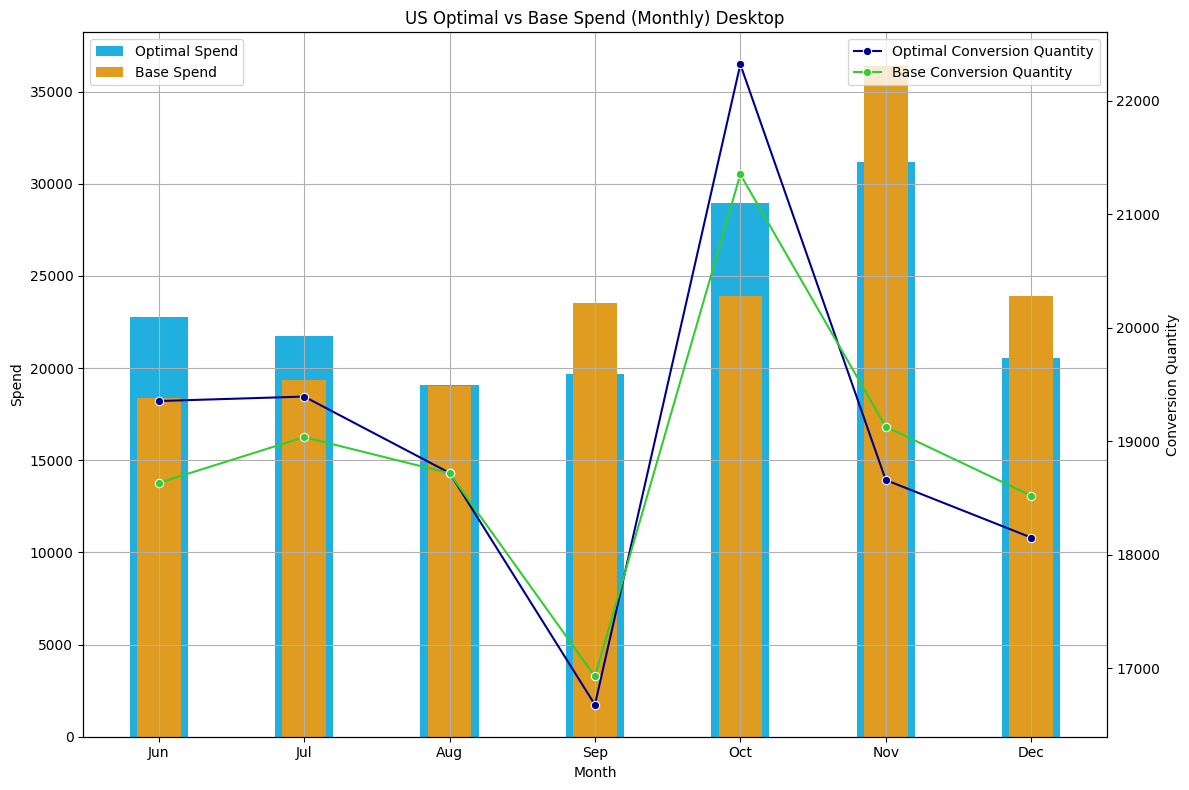

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure 'Month' is treated as datetime
#forecast_dashboard_mobile['Month'] = pd.to_datetime(forecast_dashboard_mobile['Month'])

# Initialize the matplotlib figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the bar plots using seaborn
sns.barplot(
    x='Month', y='OptimalSpendValue', data=forecast_dashboard_desktop,
    color='deepskyblue', label='Optimal Spend', ax=ax1, width=0.4, ci=None
)
sns.barplot(
    x='Month', y='BaseSpend', data=forecast_dashboard_desktop,
    color='orange', label='Base Spend', ax=ax1, width=0.3, ci=None
)

# Customize the axes and labels
ax1.set_ylabel('Spend')
ax1.set_xlabel('Month')
ax1.set_title('US Optimal vs Base Spend (Monthly) Desktop')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a secondary y-axis to plot the conversion quantities
ax2 = ax1.twinx()
sns.lineplot(
    x='Month', y='OptimalConversionQuantity', data=forecast_dashboard_desktop,
    color='darkblue', label='Optimal Conversion Quantity', ax=ax2, marker='o', ci=None
)
sns.lineplot(
    x='Month', y='BaseConversionQuantity', data=forecast_dashboard_desktop,
    color='limegreen', label='Base Conversion Quantity', ax=ax2, marker='o', ci=None
)

# Customize the secondary y-axis
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper right')

# Rotate x-tick labels for better readability
plt.xticks(rotation=45)

# Tight layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()

/var/tmp/ipykernel_42714/717091733.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/tmp/ipykernel_42714/717091733.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/tmp/ipykernel_42714/717091733.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
2024-06-06 17:17:20,839 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/s

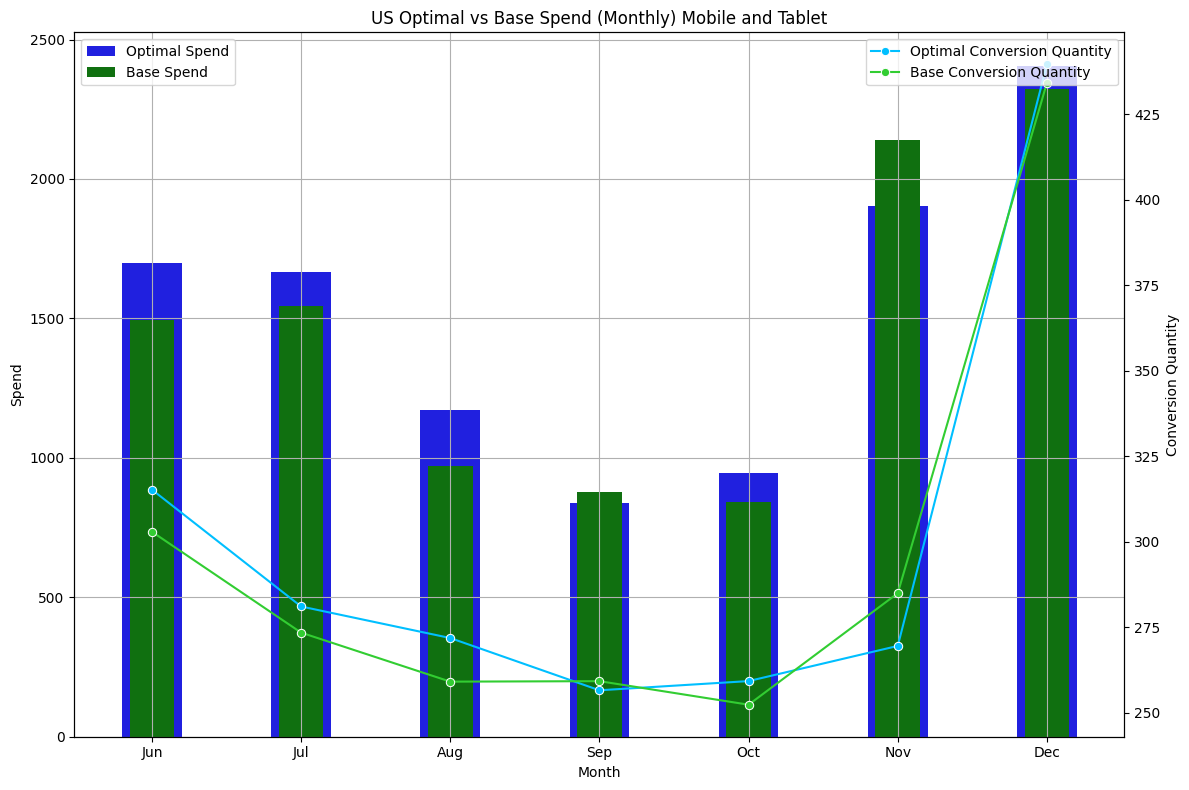

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure 'Month' is treated as datetime
#forecast_dashboard_mobile['Month'] = pd.to_datetime(forecast_dashboard_mobile['Month'])

# Initialize the matplotlib figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the bar plots using seaborn
sns.barplot(
    x='Month', y='OptimalSpendValue', data=forecast_dashboard_mobile,
    color='blue', label='Optimal Spend', ax=ax1, width=0.4, ci=None
)
sns.barplot(
    x='Month', y='BaseSpend', data=forecast_dashboard_mobile,
    color='green', label='Base Spend', ax=ax1, width=0.3, ci=None
)

# Customize the axes and labels
ax1.set_ylabel('Spend')
ax1.set_xlabel('Month')
ax1.set_title('US Optimal vs Base Spend (Monthly) Mobile and Tablet')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a secondary y-axis to plot the conversion quantities
ax2 = ax1.twinx()
sns.lineplot(
    x='Month', y='OptimalConversionQuantity', data=forecast_dashboard_mobile,
    color='deepskyblue', label='Optimal Conversion Quantity', ax=ax2, marker='o', ci=None
)
sns.lineplot(
    x='Month', y='BaseConversionQuantity', data=forecast_dashboard_mobile,
    color='limegreen', label='Base Conversion Quantity', ax=ax2, marker='o', ci=None
)

# Customize the secondary y-axis
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper right')

# Rotate x-tick labels for better readability
plt.xticks(rotation=45)

# Tight layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()